In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pandas as pd
from src.features.future_features import build_future_features
from src.utils.timeseries_split import (
    compute_min_hist, rolling_time_series_cv, select_by_index
)
from src.features.build_features import build_features
from src.pipeline.per_customer import per_customer_cv
import numpy as np
from src.data.preprocess import preprocess_all_customers
from src.data.loader import load_raw, reindex_daily
from src.eval.run_baselines import run_baselines_per_customer
from src.eval.run_candidates import run_candidates_per_customer
from src.eval.tuner import tune_per_customer
from src.pipeline.save_models_and_forecast import save_models_and_forecast

In [3]:
df = load_raw("data/raw/train set.csv") 

In [4]:
df_clean, summary = preprocess_all_customers(
    df,
    long_gap_days=30,
    min_nonzero_run=5,
    min_nonzero_value=1.0,
    gap_limit=7,
    causal=False,
    verbose=True,
)

print("Cleaned dataset shape:", df_clean.shape)
print(summary[["CUSTOMER", "inactive_lead_days", "clean_start", "clean_end"]])

[clean_and_truncate_series] {'active': True, 'orig_len': 1402, 'clean_len': 1041, 'active_days': 1041, 'orig_start': Timestamp('2019-08-01 00:00:00'), 'orig_end': Timestamp('2023-06-02 00:00:00'), 'clean_start': Timestamp('2020-07-27 00:00:00'), 'clean_end': Timestamp('2023-06-02 00:00:00'), 'inactive_lead_days': 361, 'inactive_tail_days': 11, 'gap_limit': 7, 'causal': False, 'min_nonzero_run': 5, 'min_nonzero_value': 1.0}
[clean_and_truncate_series] {'active': True, 'orig_len': 1485, 'clean_len': 1272, 'active_days': 1272, 'orig_start': Timestamp('2019-05-10 00:00:00'), 'orig_end': Timestamp('2023-06-02 00:00:00'), 'clean_start': Timestamp('2019-12-09 00:00:00'), 'clean_end': Timestamp('2023-06-02 00:00:00'), 'inactive_lead_days': 213, 'inactive_tail_days': 11, 'gap_limit': 7, 'causal': False, 'min_nonzero_run': 5, 'min_nonzero_value': 1.0}
[clean_and_truncate_series] {'active': True, 'orig_len': 2072, 'clean_len': 2072, 'active_days': 2072, 'orig_start': Timestamp('2017-09-30 00:00:0

In [5]:
# CV Config
HORIZON_DAYS = 25
STEP_DAYS    = 7
N_FOLDS      = 5        
WINDOW_TYPE  = "expanding"

# Features Config
MAX_LAG      = 30
ROLL_WINDOWS = [7, 14, 30]
MIN_HIST     = compute_min_hist(MAX_LAG, ROLL_WINDOWS)

# Holiday Config
HOLIDAY_COUNTRY = "FR"
HOLIDAY_SUBDIV_MAP = None
HOLIDAY_WINDOW = 3

In [6]:
per_fold, summary = run_baselines_per_customer(
    df_clean,
    n_folds=N_FOLDS,
    window_type=WINDOW_TYPE,
    step_days=STEP_DAYS,
    horizon_days=HORIZON_DAYS,
    gap_days=0,
    max_lag=MAX_LAG,
    roll_windows=ROLL_WINDOWS,
    holiday_country=HOLIDAY_COUNTRY,
    holiday_subdiv_map=HOLIDAY_SUBDIV_MAP,
    holiday_window=HOLIDAY_WINDOW,
    trim_by_history=True,
    dropna_mode="none",
    out_dir="outputs/cv",
    save_csv=True,
)

display(per_fold.head(12))
display(summary)

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,CUSTOMER,fold,anchor,model,MAE,RMSE,sMAPE,n
0,ARGALYS,1,2020-10-25,ETS-add,7.062005,9.619104,57.254531,25
1,ARGALYS,2,2020-11-01,ETS-add,9.150523,12.357691,60.717651,25
2,ARGALYS,3,2020-11-08,ETS-add,11.658100,15.168005,68.272525,25
3,ARGALYS,4,2020-11-15,ETS-add,10.827963,14.136137,57.958115,25
4,ARGALYS,5,2020-11-22,ETS-add,15.431875,17.725259,63.118431,25
5,ARGALYS,1,2020-10-25,Naive-1,7.400000,11.941803,59.209922,25
6,ARGALYS,2,2020-11-01,Naive-1,10.400000,14.674543,72.227014,25
7,ARGALYS,3,2020-11-08,Naive-1,13.640000,17.325335,86.776837,25
8,ARGALYS,4,2020-11-15,Naive-1,9.073333,10.623689,45.253410,25
9,ARGALYS,5,2020-11-22,Naive-1,13.100000,15.382692,57.702909,25


,CUSTOMER,model,MAE,RMSE,sMAPE
0,ARGALYS,ETS-add,10.826093,13.801239,61.464250
1,ARGALYS,Naive-1,10.722667,13.989613,64.234018
2,ARGALYS,Seasonal-7,11.413333,15.081181,71.998755
3,LES MIRACULEUX,Naive-1,63.069333,81.160743,50.154906
4,LES MIRACULEUX,Seasonal-7,63.960000,85.781058,58.437484
5,LES MIRACULEUX,ETS-mul,75.095238,97.881686,77.007965
6,MINCI DELICE,Seasonal-7,598.853333,704.685196,32.183642
7,MINCI DELICE,ETS-mul,734.093080,916.392894,32.411028
8,MINCI DELICE,Naive-1,806.928000,1039.483349,42.151194
9,NUTRAVANCE,ETS-mul,49.247973,60.020103,85.295389


In [14]:
per_fold, summary = run_candidates_per_customer(
    df_clean,
    model_matrix_path="configs/model_matrix.yaml",
    n_folds=7,
    window_type="expanding",
    step_days=7,
    horizon_days=25,
    gap_days=0,
    max_lag=30,
    roll_windows=[7,14,30],
    holiday_country="FR",
    holiday_subdiv_map=None,
    holiday_window=3,
    trim_by_history=True,
    dropna_mode="none",
    out_dir="outputs/cv/candidates",
    save_csv=True,
)

display(per_fold.head(12))
display(summary)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5731
[LightGBM] [Info] Number of data points in the train set: 789, number of used features: 62
[LightGBM] [Info] Start training from score 28.376426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11134
[LightGBM] [Info] Number of data points in the train set: 1020, number of used features: 62
[LightGBM] [Info] Start training from score 6.216900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11151
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 62
[LightGBM] [Info] Start training from score 6.220375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11169
[LightGBM] [Info] Number of data points in the train set: 1076, number of used features: 62
[LightGBM] [Info] Start training from score 6.222004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11185
[LightGBM] [Info] Number of data points in the train set: 1104, number of used features: 62
[LightGBM] [Info] Start training from score 6.227559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11206
[LightGBM] [Info] Number of data points in the train set: 1132, number of used features: 62
[LightGBM] [Info] Start training from score 6.234268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11239
[LightGBM] [Info] Number of data points in the train set: 1160, number of used features: 62
[LightGBM] [Info] Start training from score 6.242687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11507
[LightGBM] [Info] Number of data points in the train set: 2586, number of used features: 62
[LightGBM] [Info] Start training from score 4.672644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11515
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 62
[LightGBM] [Info] Start training from score 4.675714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11516
[LightGBM] [Info] Number of data points in the train set: 2642, number of used features: 62
[LightGBM] [Info] Start training from score 4.671856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11520
[LightGBM] [Info] Number of data points in the train set: 2670, number of used features: 62
[LightGBM] [Info] Start training from score 4.678217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11525
[LightGBM] [Info] Number of data points in the train set: 2698, number of used features: 62
[LightGBM] [Info] Start training from score 4.684154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11539
[LightGBM] [Info] Number of data points in the train set: 2726, number of used features: 62
[LightGBM] [Info] Start training from score 4.691454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,CUSTOMER,fold,anchor,model,MAE,RMSE,sMAPE,n
0,ARGALYS,1,2022-11-22,ARIMA,18.964105,21.803276,49.835204,25
1,ARGALYS,2,2022-12-20,ARIMA,19.702531,22.831531,41.988464,25
2,ARGALYS,3,2023-01-17,ARIMA,17.006098,20.189786,41.036454,25
3,ARGALYS,4,2023-02-14,ARIMA,17.730327,20.249600,39.785746,25
4,ARGALYS,5,2023-03-14,ARIMA,18.792480,23.282683,35.347056,25
5,ARGALYS,6,2023-04-11,ARIMA,17.938417,21.009234,45.886190,25
6,ARGALYS,1,2022-11-22,ETS-Add,13.091361,15.272972,40.878706,25
7,ARGALYS,2,2022-12-20,ETS-Add,17.042251,22.619475,38.227239,25
8,ARGALYS,3,2023-01-17,ETS-Add,14.742312,19.006131,36.486664,25
9,ARGALYS,4,2023-02-14,ETS-Add,28.102523,31.649312,55.361880,25


,CUSTOMER,model,MAE,RMSE,sMAPE
0,ARGALYS,LGBM,16.708461,21.873881,39.636620
1,ARGALYS,ETS-Add,17.641576,21.666670,41.233420
2,ARGALYS,ARIMA,18.355660,21.561018,42.313185
3,LES MIRACULEUX,SARIMA_111_111_12,269.897752,395.499483,33.561805
4,LES MIRACULEUX,LGBM,297.726005,429.650570,37.494257
5,LES MIRACULEUX,ProphetMul,316.183276,453.650690,53.149645
6,MINCI DELICE,SARIMA_weekly,538.656340,658.679033,37.082011
7,MINCI DELICE,ETS-Mul,540.445684,684.124124,38.578502
8,MINCI DELICE,ProphetMul,599.489512,731.351977,48.562729
9,NUTRAVANCE,LGBM,88.482035,112.822705,52.653735


Random

In [19]:
per_fold, summary, best_cfg = tune_per_customer(
    df_clean,
    base_yaml_path="configs/random.yaml",        # or configs/grid.yaml
    search="random",                             # "grid" or "random"
    n_trials=40,                                 # used only for random
    metric="sMAPE",                              # optimization metric
    out_yaml_path="configs/model_matrix_tuned.yaml",
    cv_defaults=dict(
        n_folds=7,
        window_type="expanding",
        step_days=28,
        horizon_days=25,
        gap_days=0,
    ),
    features_defaults=dict(
        max_lag=30,
        roll_windows=[7, 14, 30],
        holiday_country="FR",
        holiday_subdiv_map=None,
        holiday_window=3,
        trim_by_history=True,
        dropna_mode="none",
    ),
)

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization fai

[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prop

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Lik

[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.
[WARN] Prophet backend er

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization fai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5731
[LightGBM] [Info] Number of data points in the train set: 789, number of used features: 62
[LightGBM] [Info] Start training from score 28.376426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5839
[LightGBM] [Info] Number of data points in the train set: 817, number of used features: 62
[LightGBM] [Info] Start training from score 28.528152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5906
[LightGBM] [Info] Number of data points in the train set: 845, number of used features: 62
[LightGBM] [Info] Start training from score 29.172189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5982
[LightGBM] [Info] Number of data points in the train set: 873, number of used features: 62
[LightGBM] [Info] Start training from score 29.595647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6075
[LightGBM] [Info] Number of data points in the train set: 901, number of used features: 62
[LightGBM] [Info] Start training from score 30.152053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6213
[LightGBM] [Info] Number of data points in the train set: 929, number of used features: 62
[LightGBM] [Info] Start training from score 30.798708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11134
[LightGBM] [Info] Number of data points in the train set: 1020, number of used features: 62
[LightGBM] [Info] Start training from score 6.216900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11151
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 62
[LightGBM] [Info] Start training from score 6.220375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11169
[LightGBM] [Info] Number of data points in the train set: 1076, number of used features: 62
[LightGBM] [Info] Start training from score 6.222004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11185
[LightGBM] [Info] Number of data points in the train set: 1104, number of used features: 62
[LightGBM] [Info] Start training from score 6.227559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11206
[LightGBM] [Info] Number of data points in the train set: 1132, number of used features: 62
[LightGBM] [Info] Start training from score 6.234268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11239
[LightGBM] [Info] Number of data points in the train set: 1160, number of used features: 62
[LightGBM] [Info] Start training from score 6.242687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11507
[LightGBM] [Info] Number of data points in the train set: 2586, number of used features: 62
[LightGBM] [Info] Start training from score 4.672644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11515
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 62
[LightGBM] [Info] Start training from score 4.675714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11516
[LightGBM] [Info] Number of data points in the train set: 2642, number of used features: 62
[LightGBM] [Info] Start training from score 4.671856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11520
[LightGBM] [Info] Number of data points in the train set: 2670, number of used features: 62
[LightGBM] [Info] Start training from score 4.678217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11525
[LightGBM] [Info] Number of data points in the train set: 2698, number of used features: 62
[LightGBM] [Info] Start training from score 4.684154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11539
[LightGBM] [Info] Number of data points in the train set: 2726, number of used features: 62
[LightGBM] [Info] Start training from score 4.691454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [20]:
per_fold, summary = run_candidates_per_customer(
    df_clean,
    model_matrix_path="configs/model_matrix_tuned.yaml",
    n_folds=7,
    window_type="expanding",
    step_days=7,
    horizon_days=25,
    gap_days=0,
    max_lag=30,
    roll_windows=[7,14,30],
    holiday_country="FR",
    holiday_subdiv_map=None,
    holiday_window=3,
    trim_by_history=True,
    dropna_mode="none",
    out_dir="outputs/cv/candidates",
    save_csv=True,
)

display(per_fold.head(12))
display(summary)

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5731
[LightGBM] [Info] Number of data points in the train set: 789, number of used features: 62
[LightGBM] [Info] Start training from score 28.376426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5839
[LightGBM] [Info] Number of data points in the train set: 817, number of used features: 62
[LightGBM] [Info] Start training from score 28.528152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5906
[LightGBM] [Info] Number of data points in the train set: 845, number of used features: 62
[LightGBM] [Info] Start training from score 29.172189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5982
[LightGBM] [Info] Number of data points in the train set: 873, number of used features: 62
[LightGBM] [Info] Start training from score 29.595647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6075
[LightGBM] [Info] Number of data points in the train set: 901, number of used features: 62
[LightGBM] [Info] Start training from score 30.152053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6213
[LightGBM] [Info] Number of data points in the train set: 929, number of used features: 62
[LightGBM] [Info] Start training from score 30.798708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11134
[LightGBM] [Info] Number of data points in the train set: 1020, number of used features: 62
[LightGBM] [Info] Start training from score 6.216900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11151
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 62
[LightGBM] [Info] Start training from score 6.220375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11169
[LightGBM] [Info] Number of data points in the train set: 1076, number of used features: 62
[LightGBM] [Info] Start training from score 6.222004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11185
[LightGBM] [Info] Number of data points in the train set: 1104, number of used features: 62
[LightGBM] [Info] Start training from score 6.227559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11206
[LightGBM] [Info] Number of data points in the train set: 1132, number of used features: 62
[LightGBM] [Info] Start training from score 6.234268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11239
[LightGBM] [Info] Number of data points in the train set: 1160, number of used features: 62
[LightGBM] [Info] Start training from score 6.242687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11507
[LightGBM] [Info] Number of data points in the train set: 2586, number of used features: 62
[LightGBM] [Info] Start training from score 4.672644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11515
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 62
[LightGBM] [Info] Start training from score 4.675714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11516
[LightGBM] [Info] Number of data points in the train set: 2642, number of used features: 62
[LightGBM] [Info] Start training from score 4.671856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11520
[LightGBM] [Info] Number of data points in the train set: 2670, number of used features: 62
[LightGBM] [Info] Start training from score 4.678217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11525
[LightGBM] [Info] Number of data points in the train set: 2698, number of used features: 62
[LightGBM] [Info] Start training from score 4.684154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11539
[LightGBM] [Info] Number of data points in the train set: 2726, number of used features: 62
[LightGBM] [Info] Start training from score 4.691454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,CUSTOMER,fold,anchor,model,MAE,RMSE,sMAPE,n
0,ARGALYS,1,2022-11-22,ARIMA,12.555651,15.404805,38.728940,25
1,ARGALYS,2,2022-12-20,ARIMA,16.108824,21.814914,37.752501,25
2,ARGALYS,3,2023-01-17,ARIMA,13.049448,18.073767,32.435706,25
3,ARGALYS,4,2023-02-14,ARIMA,20.702399,26.725900,46.316495,25
4,ARGALYS,5,2023-03-14,ARIMA,20.021858,28.175825,39.366837,25
5,ARGALYS,6,2023-04-11,ARIMA,20.493274,23.078057,50.446396,25
6,ARGALYS,1,2022-11-22,ETS-Add,10.766650,12.334108,34.360121,25
7,ARGALYS,2,2022-12-20,ETS-Add,16.964638,22.112587,37.095720,25
8,ARGALYS,3,2023-01-17,ETS-Add,14.787441,19.017600,36.575599,25
9,ARGALYS,4,2023-02-14,ETS-Add,37.015791,41.090846,65.171713,25


,CUSTOMER,model,MAE,RMSE,sMAPE
0,ARGALYS,LGBM,16.033230,21.367778,37.265715
1,ARGALYS,ETS-Add,18.327092,22.823215,40.209897
2,ARGALYS,ARIMA,17.155242,22.212211,40.841146
3,LES MIRACULEUX,SARIMA_111_111_12,280.162056,395.511229,36.751021
4,LES MIRACULEUX,LGBM,286.359651,418.098476,37.507997
5,LES MIRACULEUX,ProphetMul,316.183276,453.650690,53.149645
6,MINCI DELICE,SARIMA_weekly,417.868882,557.226984,27.694935
7,MINCI DELICE,ETS-Mul,540.056717,681.775691,38.360201
8,MINCI DELICE,ProphetMul,599.489512,731.351977,48.562729
9,NUTRAVANCE,SARIMA_101_111_7,80.041627,97.254693,48.078952


### Peak & Seasonality Evaluation
This section derives fold-level predictions for the tuned models so we can inspect peak-demand response and residual seasonality patterns.

In [21]:
from pathlib import Path
from typing import Dict
import numpy as np
import pandas as pd
import yaml

from src.utils.timeseries_split import compute_min_hist, rolling_time_series_cv, select_by_index
from src.features.build_features import build_features
from src.features.future_features import build_future_features
from src.models import arima_like as arima
from src.models.prophet_model import fit_forecast_prophet
from src.models.gbm import fit_predict_gbm_recursive


def collect_cv_predictions(
    df_clean: pd.DataFrame,
    cfg_path: str | Path,
    *,
    n_folds: int = 5,
    window_type: str = "expanding",
    train_window_days: int | None = 365,
    step_days: int = 7,
    horizon_days: int = 25,
    gap_days: int = 0,
    initial_train_days: int = 90,
    max_lag: int = 30,
    roll_windows: list[int] = [7, 14, 30],
    holiday_country: str = "FR",
    holiday_subdiv_map: Dict[str, str] | None = None,
    holiday_window: int = 3,
    trim_by_history: bool = True,
    dropna_mode: str = "none",
) -> pd.DataFrame:
    cfg = yaml.safe_load(Path(cfg_path).read_text())
    df = df_clean.copy()
    if not np.issubdtype(df["DATE"].dtype, np.datetime64):
        df["DATE"] = pd.to_datetime(df["DATE"])
    df = df.sort_values(["CUSTOMER", "DATE"]).reset_index(drop=True)

    min_hist = compute_min_hist(max_lag, roll_windows)
    rows: list[pd.DataFrame] = []

    def _build_det_feats(slice_df: pd.DataFrame, align_index: pd.Index | None = None) -> pd.DataFrame:
        feats = build_features(
            slice_df,
            max_lag=max_lag,
            roll_windows=roll_windows,
            holiday_country=holiday_country,
            holiday_subdiv_map=holiday_subdiv_map,
            holiday_window=holiday_window,
            trim_by_history=False,
            dropna_mode="none",
            feature_set="deterministic",
        )
        if feats.empty:
            return feats
        feats = feats.set_index("DATE").sort_index()
        if align_index is not None:
            feats = feats.reindex(align_index)
        exog_cols = [c for c in feats.columns if c not in {"CUSTOMER", "QUANTITY"}]
        return feats[exog_cols].fillna(0.0).replace([np.inf, -np.inf], 0.0)

    for cust, spec in cfg["customers"].items():
        df_c = df[df["CUSTOMER"] == cust].reset_index(drop=True)
        if df_c.empty:
            continue

        transform = spec.get("transform", "raw")
        models = spec.get("models", [])
        cv_cfg = spec.get("cv", {}) or {}
        cust_window_type = cv_cfg.get("window_type", window_type)
        cust_train_window_days = cv_cfg.get("train_window_days", train_window_days)
        cust_step_days = int(cv_cfg.get("step_days", step_days))
        cust_gap_days = int(cv_cfg.get("gap_days", gap_days))
        cust_horizon_days = int(cv_cfg.get("horizon_days", horizon_days))
        cust_n_folds = int(cv_cfg.get("n_folds", n_folds))
        cust_initial_train_days = int(cv_cfg.get("initial_train_days", initial_train_days))

        if cust_window_type == "sliding":
            if cust_train_window_days is None:
                raise ValueError(f"Sliding window requires train_window_days for {cust}.")
            cust_train_window_days = int(cust_train_window_days)
        else:
            cust_train_window_days = None

        folds = rolling_time_series_cv(
            df_c,
            n_folds=cust_n_folds,
            window_type=cust_window_type,
            train_window_days=cust_train_window_days,
            step_days=cust_step_days,
            horizon_days=cust_horizon_days,
            gap_days=cust_gap_days,
            by_customer=True,
            min_hist=min_hist,
            initial_train_days=cust_initial_train_days,
        )
        if not folds:
            continue

        for f in folds:
            train_df = select_by_index(df_c, f.train_idx)
            val_df = select_by_index(df_c, f.val_idx)
            if val_df.empty:
                continue

            s_train = (
                train_df[["DATE", "QUANTITY"]]
                .set_index("DATE")
                .sort_index()["QUANTITY"]
                .asfreq("D")
                .fillna(0.0)
            )
            horizon = val_df["DATE"].nunique()
            det_train = _build_det_feats(train_df, align_index=s_train.index)
            det_future = build_future_features(
                train_df,
                horizon=horizon,
                max_lag=max_lag,
                roll_windows=roll_windows,
                holiday_country=holiday_country,
                holiday_subdiv_map=holiday_subdiv_map,
                holiday_window=holiday_window,
                feature_set="deterministic",
            )
            if not det_future.empty:
                det_future = (
                    det_future.set_index("DATE")
                    .sort_index()
                    .reindex(columns=det_train.columns)
                    .fillna(0.0)
                    .replace([np.inf, -np.inf], 0.0)
                )
            else:
                det_future = det_train.iloc[0:0]

            dates = val_df.sort_values("DATE")["DATE"].to_numpy()
            y_true = val_df.sort_values("DATE")["QUANTITY"].to_numpy()

            for m in models:
                family = m["family"]
                name = m["name"]
                params = m.get("params", {}).copy()

                try:
                    if family == "arima":
                        y_tr = np.log1p(s_train.values) if transform == "log1p" else s_train.values
                        s_tr = pd.Series(y_tr, index=s_train.index)
                        preds = arima.fit_forecast_arima(
                            s_tr,
                            horizon=horizon,
                            exog_train=None if det_train.empty else det_train.to_numpy(),
                            exog_future=None if det_future.empty else det_future.to_numpy(),
                            **params,
                        )
                        if transform == "log1p":
                            preds = np.expm1(preds)

                    elif family == "sarima":
                        y_tr = np.log1p(s_train.values) if transform == "log1p" else s_train.values
                        s_tr = pd.Series(y_tr, index=s_train.index)
                        preds = arima.fit_forecast_sarima(
                            s_tr,
                            horizon=horizon,
                            exog_train=None if det_train.empty else det_train.to_numpy(),
                            exog_future=None if det_future.empty else det_future.to_numpy(),
                            **params,
                        )
                        if transform == "log1p":
                            preds = np.expm1(preds)

                    elif family == "ets":
                        y_tr = np.log1p(s_train.values) if transform == "log1p" else s_train.values
                        s_tr = pd.Series(y_tr, index=s_train.index)
                        preds = arima.fit_forecast_ets(s_tr, horizon=horizon, **params)
                        if transform == "log1p":
                            preds = np.expm1(preds)

                    elif family == "prophet":
                        preds = fit_forecast_prophet(
                            s_train,
                            horizon=horizon,
                            exog_train=None if det_train.empty else det_train,
                            exog_future=None if det_future.empty else det_future,
                            **params,
                        )

                    elif family == "gbm":
                        preds = fit_predict_gbm_recursive(
                            train_df,
                            build_features_fn=lambda d: build_features(
                                d,
                                max_lag=max_lag,
                                roll_windows=roll_windows,
                                holiday_country=holiday_country,
                                holiday_subdiv_map=holiday_subdiv_map,
                                holiday_window=holiday_window,
                                trim_by_history=trim_by_history,
                                dropna_mode=dropna_mode,
                            ),
                            build_future_features_fn=lambda d, horizon: build_future_features(
                                d,
                                horizon=horizon,
                                max_lag=max_lag,
                                roll_windows=roll_windows,
                                holiday_country=holiday_country,
                                holiday_subdiv_map=holiday_subdiv_map,
                                holiday_window=holiday_window,
                            ),
                            horizon=horizon,
                            params=params,
                            transform=transform,
                            use_lightgbm=bool(m.get("use_lightgbm", False)),
                            max_lag=max_lag,
                            roll_windows=roll_windows,
                        )
                    else:
                        raise ValueError(f"Unsupported family: {family}")

                    rows.append(pd.DataFrame({
                        "CUSTOMER": cust,
                        "model": name,
                        "family": family,
                        "fold": f.fold,
                        "DATE": dates,
                        "y_true": y_true,
                        "y_pred": preds,
                    }))
                except Exception as exc:
                    rows.append(pd.DataFrame({
                        "CUSTOMER": [cust],
                        "model": [name],
                        "family": [family],
                        "fold": [f.fold],
                        "DATE": [pd.NaT],
                        "y_true": [np.nan],
                        "y_pred": [np.nan],
                        "error": [str(exc)],
                    }))

    if not rows:
        return pd.DataFrame()
    return pd.concat(rows, ignore_index=True)


In [22]:
import numpy as np
import pandas as pd

pred_detail = collect_cv_predictions(
    df_clean,
    cfg_path="configs/model_matrix_tuned.yaml",
    n_folds=5,
    window_type="expanding",
    step_days=28,
    horizon_days=25,
    gap_days=0,
    initial_train_days=365,
    max_lag=30,
    roll_windows=[7, 14, 30],
    holiday_country="FR",
    holiday_subdiv_map=None,
    holiday_window=3,
    trim_by_history=True,
    dropna_mode="none",
)

pred_detail = pred_detail.dropna(subset=["DATE", "y_true", "y_pred"]).copy()
if pred_detail.empty:
    print("No predictions collected.")
else:
    pred_detail["DATE"] = pd.to_datetime(pred_detail["DATE"])
    pred_detail["abs_error"] = (pred_detail["y_true"] - pred_detail["y_pred"]).abs()
    pred_detail["sq_error"] = (pred_detail["y_true"] - pred_detail["y_pred"]) ** 2
    pred_detail["sMAPE_component"] = (
        2 * (pred_detail["y_pred"] - pred_detail["y_true"]).abs()
        / (pred_detail["y_true"].abs() + pred_detail["y_pred"].abs() + 1e-8)
    )
    pred_detail["residual"] = pred_detail["y_pred"] - pred_detail["y_true"]

    peak_thresholds = (
        pred_detail.groupby("CUSTOMER")["y_true"]
        .quantile(0.9)
        .rename("peak_threshold")
    )
    pred_detail = pred_detail.join(peak_thresholds, on="CUSTOMER")
    pred_detail["is_peak"] = pred_detail["y_true"] >= pred_detail["peak_threshold"]

    peak_metrics = (
        pred_detail[pred_detail["is_peak"]]
        .groupby(["CUSTOMER", "model"])
        .agg(
            peak_MAE=("abs_error", "mean"),
            peak_RMSE=("sq_error", lambda x: float(np.sqrt(np.mean(x)))),
            peak_sMAPE=("sMAPE_component", "mean"),
            n_peak=("DATE", "count"),
        )
        .reset_index()
        .sort_values(["CUSTOMER", "peak_sMAPE"])
    )
    display(peak_metrics)

    pred_detail["day_of_week"] = pred_detail["DATE"].dt.day_name()
    pred_detail["month"] = pred_detail["DATE"].dt.month_name()

    dow_residuals = (
        pred_detail.groupby(["CUSTOMER", "model", "day_of_week"])
        .agg(
            mean_residual=("residual", "mean"),
            mae=("abs_error", "mean"),
            smape=("sMAPE_component", "mean"),
            n=("DATE", "count"),
        )
        .reset_index()
        .sort_values(["CUSTOMER", "model", "day_of_week"])
    )
    display(dow_residuals.head(20))

    month_residuals = (
        pred_detail.groupby(["CUSTOMER", "model", "month"])
        .agg(
            mean_residual=("residual", "mean"),
            mae=("abs_error", "mean"),
            smape=("sMAPE_component", "mean"),
            n=("DATE", "count"),
        )
        .reset_index()
        .sort_values(["CUSTOMER", "model", "month"])
    )
    display(month_residuals.head(20))


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5731
[LightGBM] [Info] Number of data points in the train set: 789, number of used features: 62
[LightGBM] [Info] Start training from score 28.376426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5839
[LightGBM] [Info] Number of data points in the train set: 817, number of used features: 62
[LightGBM] [Info] Start training from score 28.528152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5906
[LightGBM] [Info] Number of data points in the train set: 845, number of used features: 62
[LightGBM] [Info] Start training from score 29.172189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5982
[LightGBM] [Info] Number of data points in the train set: 873, number of used features: 62
[LightGBM] [Info] Start training from score 29.595647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6075
[LightGBM] [Info] Number of data points in the train set: 901, number of used features: 62
[LightGBM] [Info] Start training from score 30.152053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6213
[LightGBM] [Info] Number of data points in the train set: 929, number of used features: 62
[LightGBM] [Info] Start training from score 30.798708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11134
[LightGBM] [Info] Number of data points in the train set: 1020, number of used features: 62
[LightGBM] [Info] Start training from score 6.216900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11151
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 62
[LightGBM] [Info] Start training from score 6.220375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11169
[LightGBM] [Info] Number of data points in the train set: 1076, number of used features: 62
[LightGBM] [Info] Start training from score 6.222004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11185
[LightGBM] [Info] Number of data points in the train set: 1104, number of used features: 62
[LightGBM] [Info] Start training from score 6.227559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11206
[LightGBM] [Info] Number of data points in the train set: 1132, number of used features: 62
[LightGBM] [Info] Start training from score 6.234268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11239
[LightGBM] [Info] Number of data points in the train set: 1160, number of used features: 62
[LightGBM] [Info] Start training from score 6.242687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11507
[LightGBM] [Info] Number of data points in the train set: 2586, number of used features: 62
[LightGBM] [Info] Start training from score 4.672644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11515
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 62
[LightGBM] [Info] Start training from score 4.675714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11516
[LightGBM] [Info] Number of data points in the train set: 2642, number of used features: 62
[LightGBM] [Info] Start training from score 4.671856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11520
[LightGBM] [Info] Number of data points in the train set: 2670, number of used features: 62
[LightGBM] [Info] Start training from score 4.678217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11525
[LightGBM] [Info] Number of data points in the train set: 2698, number of used features: 62
[LightGBM] [Info] Start training from score 4.684154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11539
[LightGBM] [Info] Number of data points in the train set: 2726, number of used features: 62
[LightGBM] [Info] Start training from score 4.691454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,CUSTOMER,model,peak_MAE,peak_RMSE,peak_sMAPE,n_peak
1,ARGALYS,ETS-Add,36.023085,41.400145,0.484844,15
2,ARGALYS,LGBM,37.791811,43.405291,0.519129,15
0,ARGALYS,ARIMA,47.011390,48.756185,0.664398,15
4,LES MIRACULEUX,SARIMA_111_111_12,863.893520,1272.530536,0.527320,15
3,LES MIRACULEUX,LGBM,1059.683425,1407.540472,0.690772,15
6,MINCI DELICE,SARIMA_weekly,688.166317,1023.083643,0.211659,15
5,MINCI DELICE,ETS-Mul,934.543545,1268.354337,0.322697,15
9,NUTRAVANCE,SARIMA_101_111_7,175.799266,198.871202,0.512142,15
7,NUTRAVANCE,ETS-Add,210.761686,233.252927,0.654304,15
8,NUTRAVANCE,LGBM,224.309812,237.949113,0.705167,15


,CUSTOMER,model,day_of_week,mean_residual,mae,smape,n
0,ARGALYS,ARIMA,Friday,2.675529,13.328127,0.410114,24
1,ARGALYS,ARIMA,Monday,-20.018124,30.324794,0.450181,18
2,ARGALYS,ARIMA,Saturday,-1.356919,15.228898,0.383212,24
3,ARGALYS,ARIMA,Sunday,-12.716695,23.279634,0.443673,18
4,ARGALYS,ARIMA,Thursday,-0.895602,11.397871,0.376569,24
5,ARGALYS,ARIMA,Tuesday,0.966240,11.455484,0.254400,18
6,ARGALYS,ARIMA,Wednesday,-5.480301,18.470434,0.521486,24
7,ARGALYS,ETS-Add,Friday,9.179922,16.883971,0.449529,24
8,ARGALYS,ETS-Add,Monday,-10.714049,22.361314,0.330759,18
9,ARGALYS,ETS-Add,Saturday,5.159010,17.376914,0.401798,24


,CUSTOMER,model,month,mean_residual,mae,smape,n
0,ARGALYS,ARIMA,April,1.963577,19.687294,0.439244,27
1,ARGALYS,ARIMA,December,-3.398987,9.520230,0.310857,28
2,ARGALYS,ARIMA,February,-5.662507,14.546409,0.337309,25
3,ARGALYS,ARIMA,January,-9.075193,18.433386,0.386005,28
4,ARGALYS,ARIMA,March,-18.279862,20.841642,0.456138,28
5,ARGALYS,ARIMA,May,27.146880,27.146880,0.657581,6
6,ARGALYS,ARIMA,November,11.696069,18.615084,0.592491,8
7,ARGALYS,ETS-Add,April,-6.562503,15.293742,0.344012,27
8,ARGALYS,ETS-Add,December,0.591641,10.240267,0.307725,28
9,ARGALYS,ETS-Add,February,24.790192,26.598173,0.509421,25


In [7]:
per_fold, summary, peak_metrics, best_models = run_candidates_per_customer(
    df_clean,
    model_matrix_path="configs/model_matrix_tuned.yaml",
    out_dir="outputs/cv/candidates",
    save_csv=True,
)

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5731
[LightGBM] [Info] Number of data points in the train set: 789, number of used features: 62
[LightGBM] [Info] Start training from score 28.376426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5839
[LightGBM] [Info] Number of data points in the train set: 817, number of used features: 62
[LightGBM] [Info] Start training from score 28.528152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5906
[LightGBM] [Info] Number of data points in the train set: 845, number of used features: 62
[LightGBM] [Info] Start training from score 29.172189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5982
[LightGBM] [Info] Number of data points in the train set: 873, number of used features: 62
[LightGBM] [Info] Start training from score 29.595647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6075
[LightGBM] [Info] Number of data points in the train set: 901, number of used features: 62
[LightGBM] [Info] Start training from score 30.152053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6213
[LightGBM] [Info] Number of data points in the train set: 929, number of used features: 62
[LightGBM] [Info] Start training from score 30.798708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11134
[LightGBM] [Info] Number of data points in the train set: 1020, number of used features: 62
[LightGBM] [Info] Start training from score 6.216900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11151
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 62
[LightGBM] [Info] Start training from score 6.220375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11169
[LightGBM] [Info] Number of data points in the train set: 1076, number of used features: 62
[LightGBM] [Info] Start training from score 6.222004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11185
[LightGBM] [Info] Number of data points in the train set: 1104, number of used features: 62
[LightGBM] [Info] Start training from score 6.227559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11206
[LightGBM] [Info] Number of data points in the train set: 1132, number of used features: 62
[LightGBM] [Info] Start training from score 6.234268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for LES MIRACULEUX. Skipping Prophet.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11239
[LightGBM] [Info] Number of data points in the train set: 1160, number of used features: 62
[LightGBM] [Info] Start training from score 6.242687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[WARN] Prophet backend error for MINCI DELICE. Skipping Prophet.


/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11507
[LightGBM] [Info] Number of data points in the train set: 2586, number of used features: 62
[LightGBM] [Info] Start training from score 4.672644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11515
[LightGBM] [Info] Number of data points in the train set: 2614, number of used features: 62
[LightGBM] [Info] Start training from score 4.675714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11516
[LightGBM] [Info] Number of data points in the train set: 2642, number of used features: 62
[LightGBM] [Info] Start training from score 4.671856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11520
[LightGBM] [Info] Number of data points in the train set: 2670, number of used features: 62
[LightGBM] [Info] Start training from score 4.678217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11525
[LightGBM] [Info] Number of data points in the train set: 2698, number of used features: 62
[LightGBM] [Info] Start training from score 4.684154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11539
[LightGBM] [Info] Number of data points in the train set: 2726, number of used features: 62
[LightGBM] [Info] Start training from score 4.691454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [8]:
display(summary[['CUSTOMER','model','MAE','RMSE','sMAPE',
                 'MAE_norm','RMSE_norm','sMAPE_norm','CompositeScore']])
display(peak_metrics)
display(best_models[['CUSTOMER','model','CompositeScore']])

,CUSTOMER,model,MAE,RMSE,sMAPE,MAE_norm,RMSE_norm,sMAPE_norm,CompositeScore
0,ARGALYS,LGBM,16.033230,21.367778,37.265715,1.000000,1.000000,1.000000,1.000000
1,ARGALYS,ARIMA,17.155242,22.212211,40.841146,1.069980,1.039519,1.095944,1.059942
2,ARGALYS,ETS-Add,18.327092,22.823215,40.209897,1.143069,1.068114,1.079005,1.092779
3,LES MIRACULEUX,SARIMA_111_111_12,280.162056,395.511229,36.751021,1.000000,1.000000,1.000000,1.000000
4,LES MIRACULEUX,LGBM,286.359651,418.098476,37.507997,1.022121,1.057109,1.020597,1.039310
5,LES MIRACULEUX,ProphetMul,316.183276,453.650690,53.149645,1.128573,1.146998,1.446209,1.201313
6,MINCI DELICE,SARIMA_weekly,417.868882,557.226984,27.694935,1.000000,1.000000,1.000000,1.000000
7,MINCI DELICE,ETS-Mul,540.056717,681.775691,38.360201,1.292407,1.223515,1.385098,1.276499
8,MINCI DELICE,ProphetMul,599.489512,731.351977,48.562729,1.434635,1.312485,1.753488,1.437331
9,NUTRAVANCE,SARIMA_101_111_7,80.041627,97.254693,48.078952,1.000000,1.000000,1.000000,1.000000


,CUSTOMER,model,peak_sMAPE,recall_at_topk,peak_under_rate,k
0,ARGALYS,ARIMA,66.439761,0.200000,1.000000,15
1,ARGALYS,ETS-Add,48.484377,0.266667,0.800000,15
2,ARGALYS,LGBM,51.912918,0.266667,0.866667,15
3,LES MIRACULEUX,LGBM,69.077213,0.466667,1.000000,15
4,LES MIRACULEUX,ProphetMul,53.662766,0.533333,0.933333,15
5,LES MIRACULEUX,SARIMA_111_111_12,52.732012,0.533333,0.866667,15
6,MINCI DELICE,ETS-Mul,32.269678,0.600000,0.666667,15
7,MINCI DELICE,ProphetMul,27.702702,0.533333,0.733333,15
8,MINCI DELICE,SARIMA_weekly,21.165860,0.733333,0.733333,15
9,NUTRAVANCE,ETS-Add,65.430405,0.200000,1.000000,15


,CUSTOMER,model,CompositeScore
0,ARGALYS,LGBM,1.0
1,LES MIRACULEUX,SARIMA_111_111_12,1.0
2,MINCI DELICE,SARIMA_weekly,1.0
3,NUTRAVANCE,SARIMA_101_111_7,1.0


In [18]:
forecast_df = save_models_and_forecast(
    df_clean,
    best_yaml_path="outputs/cv/candidates/best_models_composite.yaml",
    horizon=21,
    models_dir="outputs/models",
    forecasts_path="outputs/forecasts/forecast_quantiles.csv",
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6565
[LightGBM] [Info] Number of data points in the train set: 1041, number of used features: 62
[LightGBM] [Info] Start training from score 29.840058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/saab/Documents/DSBA/Interviews/Alki/alki-forecast/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
display(forecast_df.head())

,CUSTOMER,DATE,model,family,P10,P50,P90
0,ARGALYS,2023-06-03,LGBM,gbm,31.295413,34.429459,37.563504
1,ARGALYS,2023-06-04,LGBM,gbm,34.545947,37.679993,40.814038
2,ARGALYS,2023-06-05,LGBM,gbm,38.604599,41.738644,44.872690
3,ARGALYS,2023-06-06,LGBM,gbm,26.531612,29.665658,32.799703
4,ARGALYS,2023-06-07,LGBM,gbm,26.375010,29.509056,32.643101


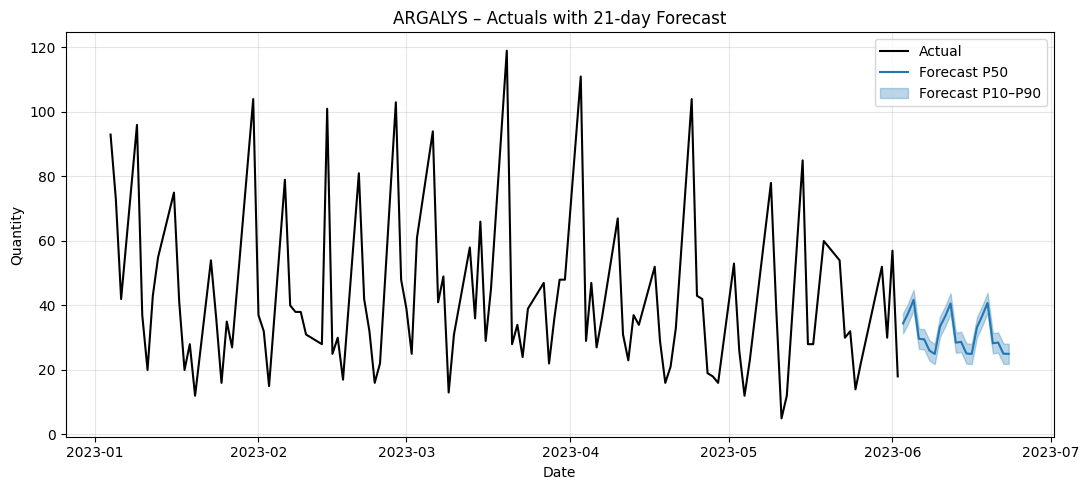

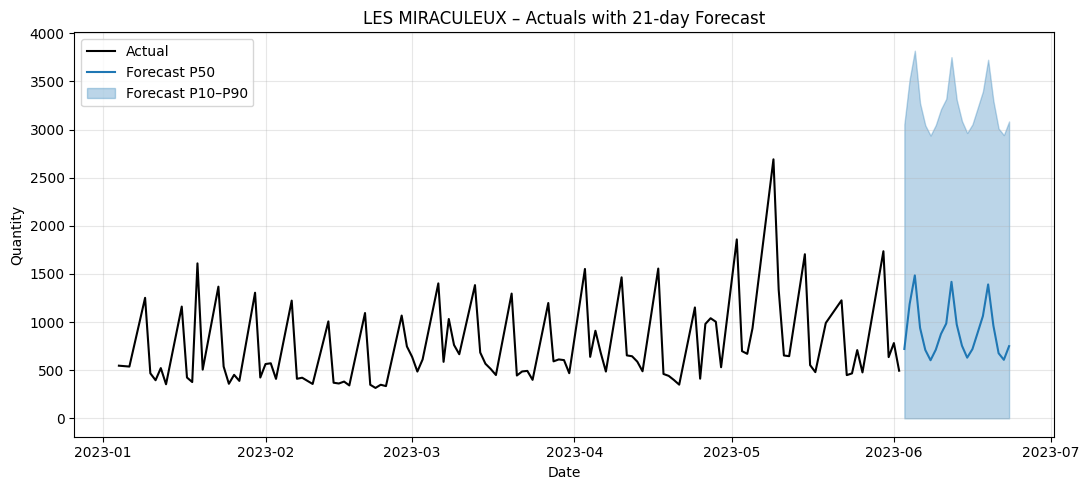

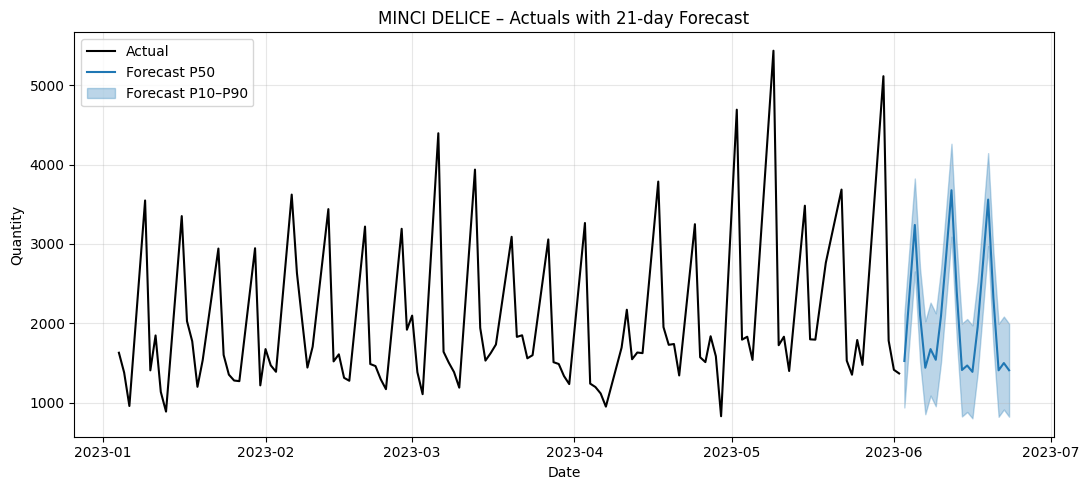

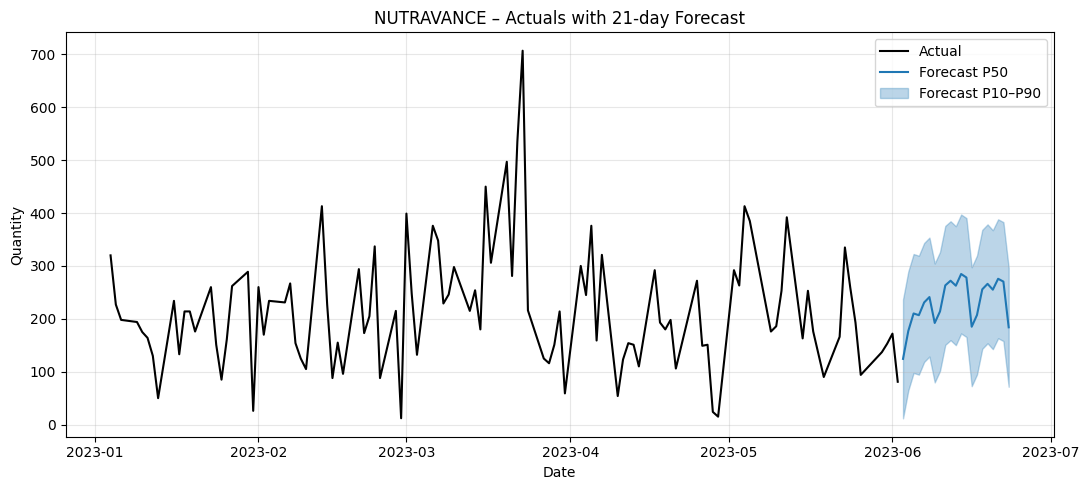

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# choose customer to visualise
customers = df_clean["CUSTOMER"].unique()

for cust in customers:
    hist_tail = (
        df_clean[df_clean["CUSTOMER"] == cust]
        .sort_values("DATE")
        .tail(150)                                     # last ~3 months
        .assign(source="actual")
    )

    forecast_plot = (
        forecast_df[forecast_df["CUSTOMER"] == cust]
        .sort_values("DATE")
        .assign(source="forecast")
    )

    fig, ax = plt.subplots(figsize=(11, 5))

    # historical actuals
    ax.plot(hist_tail["DATE"], hist_tail["QUANTITY"], label="Actual", color="black")

    # forecast median and shaded band
    ax.plot(forecast_plot["DATE"], forecast_plot["P50"], label="Forecast P50", color="tab:blue")
    ax.fill_between(
        forecast_plot["DATE"],
        forecast_plot["P10"],
        forecast_plot["P90"],
        color="tab:blue",
        alpha=0.3,
        label="Forecast P10–P90"
    )

    ax.set_title(f"{cust} – Actuals with 21-day Forecast")
    ax.set_xlabel("Date")
    ax.set_ylabel("Quantity")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [21]:
print("Last actual date:", df_clean[df_clean["CUSTOMER"]=="ARGALYS"]["DATE"].max())
print("Forecast start:", forecast_df["DATE"].min())
print("Forecast end:", forecast_df["DATE"].max())

Last actual date: 2023-06-02 00:00:00
Forecast start: 2023-06-03 00:00:00
Forecast end: 2023-06-23 00:00:00
